In [4]:
import yfinance as yf
import pandas as pd
import numpy as np

tickers = {
    'S&P 500': '^SPX',
    'VIX': '^VIX',
    'US10Y': '^TNX',
    'JPMorgan': 'JPM',
}
start_date = '2020-01-01'
end_date = '2025-01-31'
data = yf.download(list(tickers.values()), start=start_date, end=end_date)
closing_price = data['Close']
returns = closing_price.pct_change().dropna() #use for CAPM
df_pct = pd.DataFrame(returns)
df = pd.DataFrame(closing_price)

df


[*********************100%***********************]  4 of 4 completed


Ticker,JPM,^SPX,^TNX,^VIX
Date,,,,
2020-01-02,121.477234,3257.850098,1.882,12.470000
2020-01-03,119.874161,3234.850098,1.788,14.020000
2020-01-06,119.778839,3246.280029,1.811,13.850000
2020-01-07,117.742516,3237.179932,1.827,13.790000
2020-01-08,118.661064,3253.050049,1.874,13.450000
...,...,...,...,...
2025-01-24,264.839996,6101.240234,4.626,14.850000
2025-01-27,265.850006,6012.279785,4.528,17.900000
2025-01-28,267.140015,6067.700195,4.551,16.410000


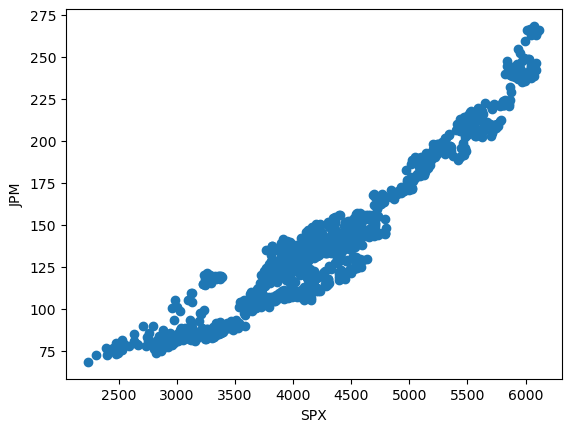

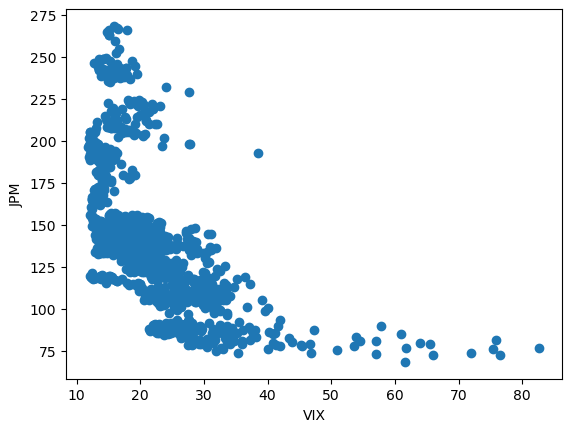

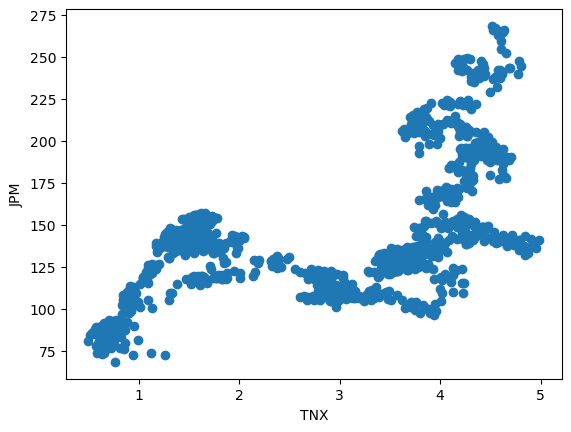

Ticker,JPM,^SPX,^TNX,^VIX
Ticker,,,,
JPM,1.00,0.96,0.65,-0.59
^SPX,0.96,1.00,0.67,-0.63
^TNX,0.65,0.67,1.00,-0.48
^VIX,-0.59,-0.63,-0.48,1.00


In [5]:
#add scatter plots of independent variables with dependent and see correlations
import matplotlib.pyplot as plt
plt.scatter(df['^SPX'], df['JPM'])
plt.xlabel('SPX')
plt.ylabel('JPM')
plt.show()
plt.scatter(df['^VIX'], df['JPM'])
plt.xlabel('VIX')
plt.ylabel('JPM')
plt.show()
plt.scatter(df['^TNX'], df['JPM'])
plt.xlabel('TNX')
plt.ylabel('JPM')
plt.show()

df.corr().round(2)

In [7]:
#calculate beta and expected return using CAPM, just because
covariance = df_pct['JPM'].cov(df_pct['^SPX'])

beta = covariance / df_pct['^SPX'].var()


expected_return = df['^TNX'].iloc[-1] + beta * (df_pct['^SPX'].mean()*252*100 - df['^TNX'].iloc[-1])
print (expected_return.round(2),'%')


15.35 %


In [10]:
#move pd data frame into np so I can use sklearn
df_np = df.to_numpy()
df_np.shape
df_np

array([[1.21477234e+02, 3.25785010e+03, 1.88199997e+00, 1.24700003e+01],
       [1.19874161e+02, 3.23485010e+03, 1.78799999e+00, 1.40200005e+01],
       [1.19778839e+02, 3.24628003e+03, 1.81099999e+00, 1.38500004e+01],
       ...,
       [2.67140015e+02, 6.06770020e+03, 4.55100012e+00, 1.64099998e+01],
       [2.66579987e+02, 6.03931006e+03, 4.55499983e+00, 1.65599995e+01],
       [2.68230011e+02, 6.07116992e+03, 4.51200008e+00, 1.58400002e+01]])

In [12]:
x_train, y_train = df_np[:, -3:], df_np[:, 0]
x_train.shape, y_train.shape
x_train

array([[3.25785010e+03, 1.88199997e+00, 1.24700003e+01],
       [3.23485010e+03, 1.78799999e+00, 1.40200005e+01],
       [3.24628003e+03, 1.81099999e+00, 1.38500004e+01],
       ...,
       [6.06770020e+03, 4.55100012e+00, 1.64099998e+01],
       [6.03931006e+03, 4.55499983e+00, 1.65599995e+01],
       [6.07116992e+03, 4.51200008e+00, 1.58400002e+01]])

In [14]:
from sklearn.linear_model import LinearRegression

sklearn_model = LinearRegression().fit(x_train, y_train)
sklearn_y_predictions = sklearn_model.predict(x_train)
from sklearn.metrics import mean_absolute_error, mean_squared_error

print (mean_absolute_error(sklearn_y_predictions, y_train))
print (mean_squared_error(sklearn_y_predictions, y_train))


8.978260701590917
141.37765193836816


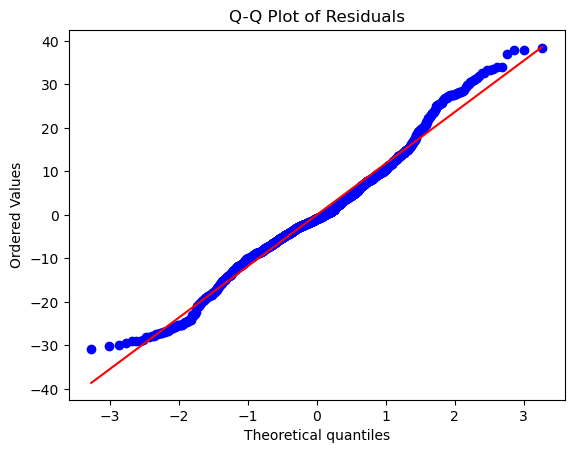

In [15]:
#create a qq plot to visualize residuals
import scipy.stats as stats
residuals = y_train - sklearn_y_predictions
stats.probplot(residuals, dist='norm', plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


In [18]:
def get_predictions(model, X):
  '''
  Obtain the predictions for the given model and inputs.

  model: np.array of Floats with shape (p,) of parameters
  X: np.array of Floats with shape (n, p-1) of inputs
  
  Returns: np.array of Floats with shape (n,).
  '''

  (n, p_minus_one) = X.shape
  p = p_minus_one + 1

  new_X = np.ones(shape=(n, p))
  new_X[:, 1:] = X

  return np.dot(new_X, model)

In [20]:
test_model = np.array([1,1,1,1.2])
get_predictions(test_model, x_train).shape


(1277,)

In [22]:
from numpy.linalg import inv

def get_best_model(X, y):

  (n, p_minus_one) = X.shape
  p = p_minus_one + 1

  new_X = np.ones(shape=(n, p))
  new_X[:, 1:] = X

  return np.dot(np.dot(inv(np.dot(new_X.T, new_X)), new_X.T), y)

In [31]:
predictions_df = pd.DataFrame({'^SPX': df['^SPX'],
                               '^TNX': df['^TNX'],
                               '^VIX': df['^VIX'],
                               'JPM': df['JPM'],
                               'Sklearn JPM Predictions':sklearn_y_predictions})

best_model = get_best_model(x_train, y_train)
predictions_df['Best Predictions'] = get_predictions(best_model, x_train)
predictions_df.round(6)



,^SPX,^TNX,^VIX,JPM,Sklearn JPM Predictions,Best Predictions
Date,,,,,,
2020-01-02,3257.850098,1.882,12.470000,121.477234,87.525489,87.525489
2020-01-03,3234.850098,1.788,14.020000,119.874161,86.566756,86.566756
2020-01-06,3246.280029,1.811,13.850000,119.778839,87.123329,87.123329
2020-01-07,3237.179932,1.827,13.790000,117.742516,86.661874,86.661874
2020-01-08,3253.050049,1.874,13.450000,118.661064,87.423972,87.423972
...,...,...,...,...,...,...
2025-01-24,6101.240234,4.626,14.850000,264.839996,231.591930,231.591930
2025-01-27,6012.279785,4.528,17.900000,265.850006,227.534023,227.534023
2025-01-28,6067.700195,4.551,16.410000,267.140015,230.110387,230.110387


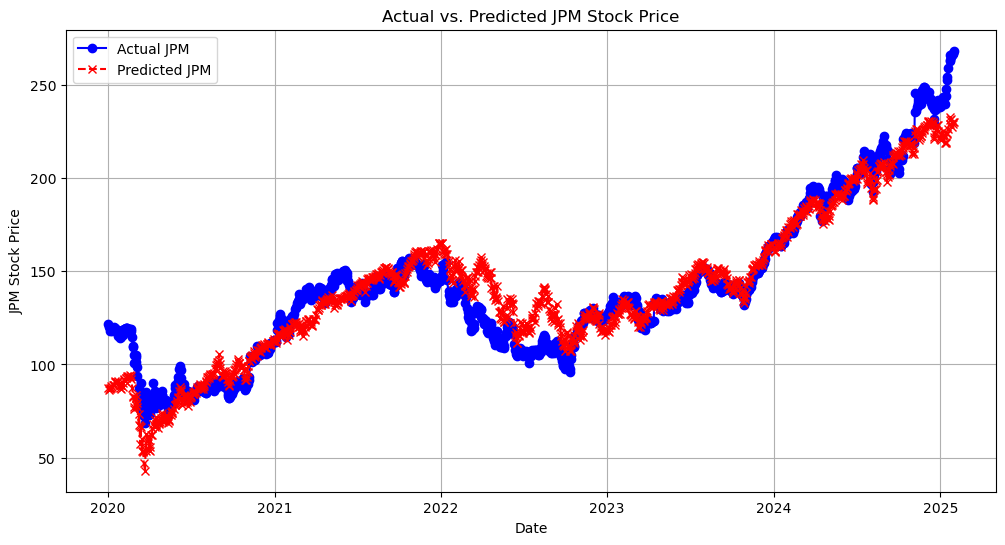

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, predictions_df['JPM'], label='Actual JPM', color='blue', linestyle='-', marker='o')
plt.plot(df.index, predictions_df['Sklearn JPM Predictions'], label='Predicted JPM', color='red', linestyle='--', marker='x')

plt.xlabel('Date')
plt.ylabel('JPM Stock Price')
plt.title('Actual vs. Predicted JPM Stock Price')
plt.legend()
plt.grid()

plt.show()

In [33]:
#see regression results
import statsmodels.api as sm

x_train_sm = sm.add_constant(x_train)

ols_model = sm.OLS(y_train, x_train_sm).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     4614.
Date:                Sun, 09 Feb 2025   Prob (F-statistic):               0.00
Time:                        22:19:27   Log-Likelihood:                -4973.5
No. Observations:                1277   AIC:                             9955.
Df Residuals:                    1273   BIC:                             9976.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -78.5856      3.227    -24.352      0.0

In [39]:
#export to excel
with pd.ExcelWriter('output.xlsx', engine='openpyxl') as writer:
    predictions_df.to_excel(writer, sheet_name='Sheet1', index=False)
predictions_df.to_excel('output.xlsx', sheet_name='Sheet1', index=False)